In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpcsvkmeuaafdfjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpbpblogspotcomedLMjVpRGkSWexgsXjkNIAAAAAAAADWgFFtAUqBlhAsjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTENDgMDUODczNDcNTcjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpcsvkmeuadecafjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/mindy_kaling/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIOTcwODQNTUzNjQMzcjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/mindy_kaling/httpcdncdnjustjaredcomwpcontentuploadsheadlinesmindykalingcomedypilotjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/mindy_kaling/httpdbrbzkkbdsdcloudfrontnetwpcontentuploadsMindyKalingjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/mindy_kaling/httpcdnpastemagazinecomw

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import train_test_split
# Assuming that we are on a CUDA machine, this should print a CUDA device:
from tempfile import TemporaryDirectory
print(device)

cuda:0


In [52]:
#using AlexNet we will aim to train classifier of celebrities
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [53]:
data_dir = '/kaggle/input/5-celebrity-faces-dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
#load data
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


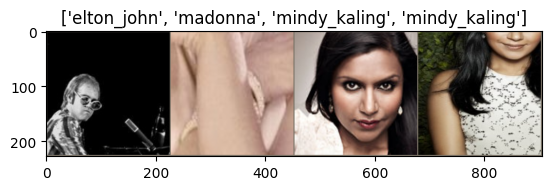

In [54]:
#data visualisation
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [55]:
#model training
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [56]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [100]:
#Load model and freeze all except the final layer
model_conv = torchvision.models.alexnet(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 5)
model_conv = model_conv.to(device)
print(model_conv)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.classifier[6].parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [101]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.5478 Acc: 0.3441
val Loss: 1.0822 Acc: 0.5200

Epoch 1/49
----------
train Loss: 1.0831 Acc: 0.6667
val Loss: 0.9270 Acc: 0.7200

Epoch 2/49
----------
train Loss: 0.8255 Acc: 0.7419
val Loss: 0.7508 Acc: 0.8400

Epoch 3/49
----------
train Loss: 0.7668 Acc: 0.7742
val Loss: 0.6938 Acc: 0.7600

Epoch 4/49
----------
train Loss: 0.5081 Acc: 0.8495
val Loss: 0.6728 Acc: 0.7200

Epoch 5/49
----------
train Loss: 0.6257 Acc: 0.8172
val Loss: 0.6449 Acc: 0.8000

Epoch 6/49
----------
train Loss: 0.5072 Acc: 0.8602
val Loss: 0.6445 Acc: 0.7200

Epoch 7/49
----------
train Loss: 0.5133 Acc: 0.8172
val Loss: 0.6237 Acc: 0.8000

Epoch 8/49
----------
train Loss: 0.6422 Acc: 0.7849
val Loss: 0.6148 Acc: 0.8400

Epoch 9/49
----------
train Loss: 0.6140 Acc: 0.7849
val Loss: 0.5887 Acc: 0.8400

Epoch 10/49
----------
train Loss: 0.4638 Acc: 0.9140
val Loss: 0.5864 Acc: 0.8400

Epoch 11/49
----------
train Loss: 0.5256 Acc: 0.8387
val Loss: 0.5845 Acc: 0.8400

Ep

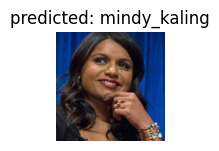

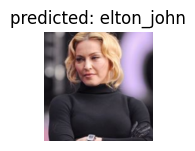

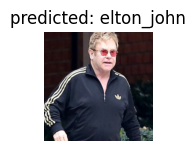

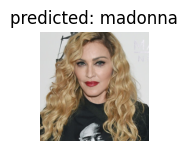

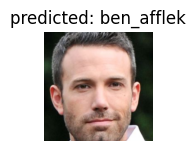

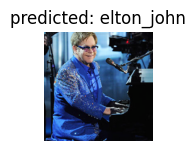

In [59]:
visualize_model(model_conv)

plt.ioff()
plt.show()